# Infection Modeling Changing R0 for San Diego County

The SIR infection model is a simple set of differential equalitations that describe how a disease can spread under very homogeneous conditions. The model gets it's name from the three "compartments" for people in diferent conditions: 

* Susceptible: people who can be infected.
* Infected: people who are infected.
* Recovered or Removed: people who were infected, and can't get infected again. 

There are [many good overviews](https://www.maa.org/press/periodicals/loci/joma/the-sir-model-for-spread-of-disease-the-differential-equation-model) of the model online, so in this brief analysis, we will just use the model to visuaize what happens when the $R$ parameter for an epidemic changes. 

$R$ is the ["efective reproduction number"](https://www.healthknowledge.org.uk/public-health-textbook/research-methods/1a-epidemiology/epidemic-theory) of a disease, which describes the rate of increase of infection for curent conditions. It differs from the similar number, the basic reproduction number $R_0$, in that $R$ can change, but $R_0$ cannot. 

The SIR model doesn't use $R$ or $R_0$ directly; it uses an infection rate $\beta$ and recovery rate $\gamma$, and $R_0$ = $\frac{\beta N}{\gamma}$, where $N$ is the total population.  In this simulation, we'll use the SIR model to see what happens when a popuation the size of San Diego County gets one infection, with a constant $R_0$ and where $R$ changes from $R0$ to a lower value. We will change $R$ by changing $\beta$ and leaving $\gamma$ constant, which is a simple simulation of San Diego impementing a social distancing policy. 



In [1]:
import sys
# Install required packages
!{sys.executable} -mpip -q install matplotlib seaborn statsmodels pandas publicdata metapack

%matplotlib inline

import pandas as pd
import geopandas as gpd
import numpy as np
import metapack as mp
import rowgenerators as rg
import publicdata as pub
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from statsmodels.nonparametric.smoothers_lowess import lowess

from scipy.integrate import odeint


In [14]:
from functools import partial 

def sir_diff( N, beta, gamma, sir, t):
    """Calculate new difference values for input values"""
    # sir[0] - S, sir[1] - I, sir[2] - R
    dsdt = - (beta * sir[0] * sir[1])/N
    didt = (beta * sir[0] * sir[1])/N - gamma * sir[1]
    drdt = gamma * sir[1]
    
    return [dsdt, didt, drdt]


def make_sir_df(N, t, sir, kn_rate=.15):
    df = pd.DataFrame({
        't' : t,
        'S' : sir[:, 0],
        'I' : sir[:, 1],
        'R' : sir[:, 2],
    }).set_index('t')

    df = df.groupby(np.round(df.index).astype(int)).mean()

    #df['known_cases'] = (N-df.S)*kn_rate
    # San Diegos data starts with 8 cases, so make that day zero
    #day_0_idx = (df.known_cases-8).abs().idxmin()
    #df = df.shift(-day_0_idx)

    return df

def solve_sir(N, beta, gamma):
    """Solve it with ODEINT"""
    #N = 3.2e6
    S = N - 1
    I = 1
    R = 0
    #beta = 0.6 # infection rate
    #gamma = 0.2 # recovery rate

    # initial conditions
    sir0 = (S, I, R)

    # time points
    t = np.linspace(0, 100, num=1000)

    # solve ODE
    # the parameters are, the equations, initial conditions, 
    # and time steps (between 0 and 100)
    
    f = partial(sir_diff, N, beta, gamma)
    
    return t, odeint(f, sir0, t)

    
def make_sir(N, beta, gamma):
    
    t, s = solve_sir(N, beta, gamma)
    
    return make_sir_df(N, t, s)
    
def iter_sir(t, N, beta, gamma):
    
    params = (N-1, 1, 0)
    
    dv = len(t)/max(t)
    
    for i, t_ in enumerate(t):
              
        try:
            b = beta[i]
        except TypeError:
            b = beta
        
        try:
            g = gamma[i]
        except TypeError:
            g = gamma
        
        
        diff = np.array(sir_diff(N, b, g, params, t_))/dv
        yield params
        params = np.add(params, diff)
 
def make_sir_i(N, beta, gamma, days, points):
    """Solve it by iterating. Not as accurate, but allows beta and gama to change. """
    t = np.linspace(0, days, num=points)
    s = np.array(list(iter_sir(t, N, beta, gamma)))
    df_i = make_sir_df(N, t, s)
    return df_i
    


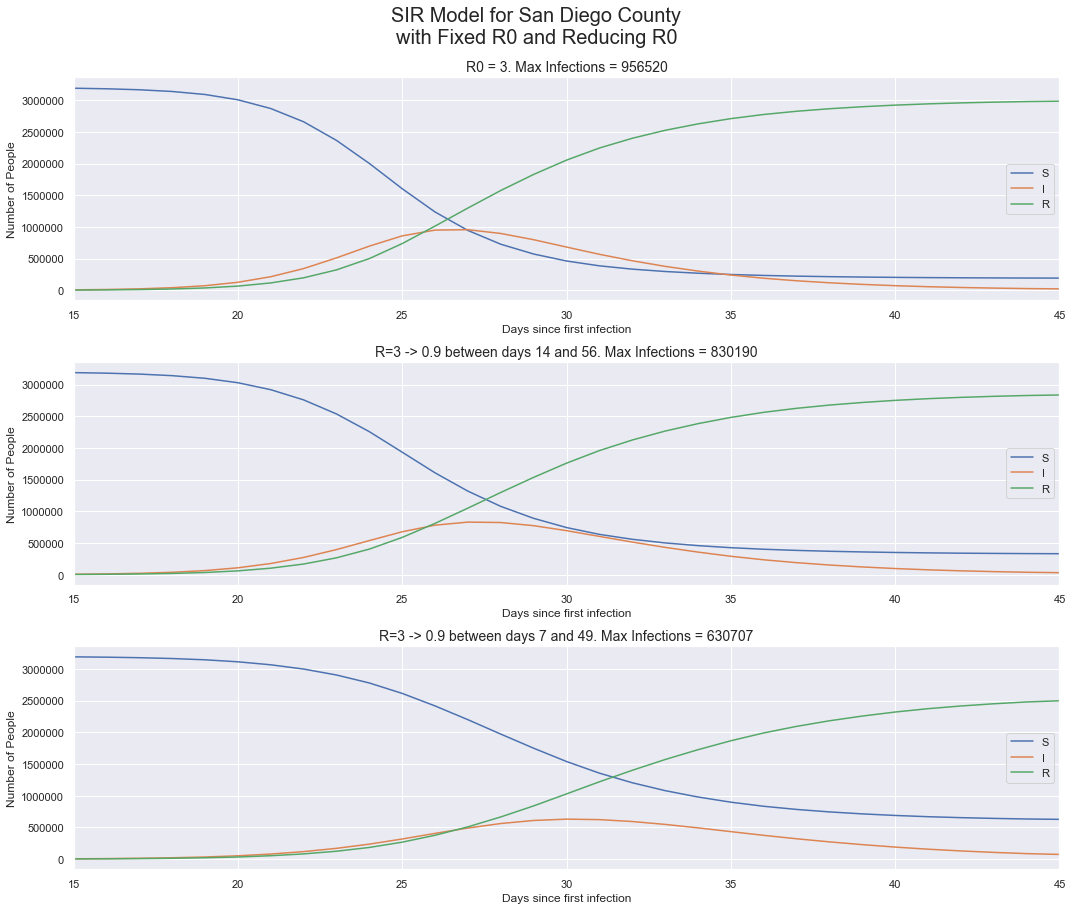

In [26]:
fig, ax = plt.subplots(3, 1, figsize=(15,12))
fig.suptitle("SIR Model for San Diego County\nwith Fixed R0 and Reducing R0", fontsize=20, y=1.05);

N = 3.2e6 
gamma =  .3

r1 = 3
r2 = .9
beta1 = r1 * gamma
beta2 = r2 * gamma

days = 45
points = 1000

pdf = points/days # days to points conversion

# Fixed

df_i = make_sir_i(N, beta1,  gamma, days, points)
ax[0].set_title(f'R0 = {r1}. Max Infections = {df_i.I.max().round(0).astype(int)}', fontsize=14)
df_i.plot(ax=ax[0])
ax[0].set_ylabel('Number of People')
ax[0].set_xlabel('Days since first infection')
ax[0].set_xlim(15,days)
# Reduction of R0 from 3 to .9 between days 20 and 80

n = 1000
t1 = 14
t2 = t1+(7*6)

beta = np.concatenate( (np.array([beta1]*int(t1*pdf)),  
                        np.linspace(beta1, beta2, num=int(t1+t2)*pdf),  
                        np.array([beta2]*int(n-((t1+t2)*pdf)))), axis=0 )
df_i = make_sir_i(N, beta, gamma, days, points)

ax[1].set_title(f'R={r1} -> {r2} between days {t1} and {t2}. Max Infections = {df_i.I.max().round(0).astype(int)}', fontsize=14)
df_i.plot(ax=ax[1])
ax[1].set_ylabel('Number of People')
ax[1].set_xlabel('Days since first infection')
ax[1].set_xlim(15,days)
plt.tight_layout()

# Reduction of R0 from 3 to .9 between days 20 and 80

n = 1000
t1 = 7
t2 = t1+(7*6)

beta = np.concatenate( (np.array([beta1]*int(t1*pdf)),  
                        np.linspace(beta1, beta2, num=int(t1+t2)*pdf), 
                        np.array([beta2]*int(n-((t1+t2)*pdf)))), axis=0 )
df_i = make_sir_i(N, beta, gamma, days, points)

ax[2].set_title(f'R={r1} -> {r2} between days {t1} and {t2}. Max Infections = {df_i.I.max().round(0).astype(int)}', fontsize=14)
df_i.plot(ax=ax[2])
ax[2].set_ylabel('Number of People')
ax[2].set_xlabel('Days since first infection')
ax[2].set_xlim(15,days)
plt.tight_layout()



These three plots similate first a constant $R_0$ and then two social distancing policies, one that is implemented at day 7, continues for 6 weeks and drives $R$ down to .9, and a second that has similar parameters but is impemented a week earlier, at day 7. Note that the $I$ variable, infections, is the count of current infections; the green line for recovered people shows the number of people who have ever been infected. In this model, most people get infected eventually, but the third case, social distancing at the first week, has about 600K fewer total infections (recovered) than not implemeting the policy. For COVID-19 and a 1% to 2% fatality rate, the early implementation of the social distance policy would save 6,000 to 12,000 lives. 

The orange line for $I$ shows the current number of infected people, is an indication of the strain on the hosptal system, and early implementation of the policy reduces the peak by 200,000 infections over the late policy, and 300,000 over no policy. 

These simulations are very hard to match up to historic data, so the SIR model is not very useful for preducting actually numbers of infections, but since the dymanics are accurate, even if the numbers are not, it does a very good job of illustrating the likely effects of simple policy changes. 